Successfully read data with 999 rows and 49 columns


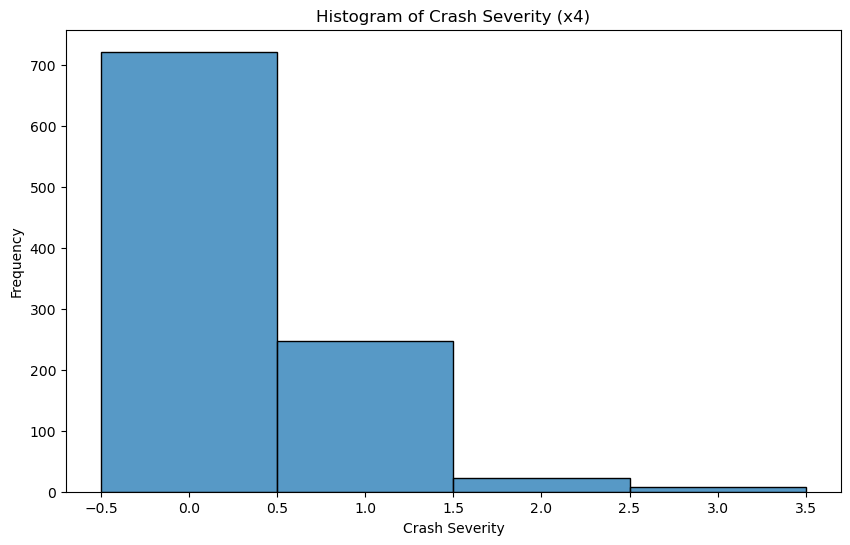


=== Regular Ordered Probit Model ===
         Current function value: 0.667198
         Iterations: 42
         Function evaluations: 93
         Gradient evaluations: 82

OrderedModel Results
Dep. Variable:            x4
Log-Likelihood:           -666.53
Model:                    OrderedModel
AIC:                      1351.06
Method:                   Maximum Likelihood
BIC:                      1395.22
Date:                     Mon, 17 Mar 2025
Time:                     22:45:26
No. Observations:         999
Df Residuals:             990
Df Model:                 9

Ordered Probit Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
winter        -0.2536      0.183     -1.389      0.165      -0.612       0.104
x19            0.1262      0.077      1.645      0.100      -0.024       0.277
x18           -0.0425      0.007     -5.748      0.000      -0.057      -0.028

Class 2 Model:

Class 1 Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
winter        -0.4848      0.245     -1.982      0.047      -0.964      -0.005
x19            0.1341      0.090      1.485      0.137      -0.043       0.311
x18           -0.0459      0.010     -4.797      0.000      -0.065      -0.027
x22            0.0002      0.000      1.332      0.183      -0.000       0.001
x36            0.5404      0.258      2.092      0.036       0.034       1.047
x40         1.403e-06    7.7e-07      1.821      0.069   -1.07e-07    2.91e-06
0/1           -0.7743      0.675     -1.147      0.251      -2.097       0.548
1/2            0.2577      0.079      3.243      0.001       0.102       0.413
2/3           -0.5514      0.252     -2.184      0.029      -1.046      -0.057

Class 2 Model Summary:
                 coef    std err          z      P>|z|      [0.025  

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
import re
from datetime import datetime
warnings.filterwarnings('ignore')

# File path options - uncomment the one that works for you
# Option 1: Raw string
data_path = r"D:\Courses\CE 7090 -Statistical and Econometric Methods in Civil Engineering II\HomeWork\HW-4\HW4 Data.txt"

# Check if file exists
if not os.path.exists(data_path):
    print(f"Warning: File not found at {data_path}")
    print("Looking for the file in the current directory...")
    
    # Try to find the file in the current directory
    current_dir = os.getcwd()
    possible_paths = [
        os.path.join(current_dir, "HW4 Data.txt"),
        os.path.join(current_dir, "HW4_Data.txt"),
        os.path.join(current_dir, "Data.txt")
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            data_path = path
            print(f"Found file at: {data_path}")
            break
    else:
        print("File not found. Please check the file path.")
        exit(1)

# Read the data - fix escape sequence issue by using regex pattern
try:
    data = pd.read_csv(data_path, sep=r'\s+', header=None, engine='python')
    print(f"Successfully read data with {data.shape[0]} rows and {data.shape[1]} columns")
except Exception as e:
    print(f"Error reading the file: {e}")
    exit(1)

# Rename columns to match NLOGIT variables
column_names = [f'x{i}' for i in range(1, data.shape[1] + 1)]
data.columns = column_names

# Create variables as in NLOGIT code
data['winter'] = ((data['x20'] == 4) | (data['x20'] == 8)).astype(int)
data['fixedobj'] = (data['x18'] == 50).astype(int)
data['young'] = (data['x25'] < 30).astype(int)

# Create panel data structure
data['id'] = data.groupby('x3').ngroup() + 1  # Create unique ID for each road segment
data = data.sort_values('id')  # Sort by ID
data['ti'] = data.groupby('id')['id'].transform('count')  # Count crashes per segment

# Histogram of x4 (crash severity)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='x4', discrete=True, kde=False)
plt.title('Histogram of Crash Severity (x4)')
plt.xlabel('Crash Severity')
plt.ylabel('Frequency')
plt.savefig('crash_severity_histogram.png')  # Save figure in case plt.show() doesn't work
plt.show()

# Function to print model results in a formatted table
def print_model_results(model, model_name, n_obs, n_params, log_likelihood, aic, bic):
    print(f"\n{model_name} Results")
    print("=" * 78)
    print(f"{'Dep. Variable:':<25} x4")
    print(f"{'Log-Likelihood:':<25} {log_likelihood:.2f}")
    print(f"{'Model:':<25} OrderedModel")
    print(f"{'AIC:':<25} {aic:.2f}")
    print(f"{'Method:':<25} Maximum Likelihood")
    print(f"{'BIC:':<25} {bic:.2f}")
    print(f"{'Date:':<25} {datetime.now().strftime('%a, %d %b %Y')}")
    print(f"{'Time:':<25} {datetime.now().strftime('%H:%M:%S')}")
    print(f"{'No. Observations:':<25} {n_obs}")
    print(f"{'Df Residuals:':<25} {n_obs - n_params}")
    print(f"{'Df Model:':<25} {n_params}")
    print("=" * 78)

# Function for regular ordered probit model
def run_ordered_probit(data):
    print("\n=== Regular Ordered Probit Model ===")
    
    # Prepare data - DON'T add a constant, let OrderedModel do it
    X = data[['winter','x19','x18','x22','x36','x40']]
    y = data['x4']
    
    # Fit the model with add_constant=True to let it handle the constant
    model = OrderedModel(y, X, distr='probit')
    result = model.fit(method='bfgs', maxiter=1000)
    
    # Print results in a formatted table
    n_obs = len(data)
    n_params = len(result.params)
    log_likelihood = result.llf
    aic = result.aic
    bic = result.bic
    
    print_model_results(result, "OrderedModel", n_obs, n_params, log_likelihood, aic, bic)
    
    # Print summary statistics for the first model - ADDED THIS PART
    print("\nOrdered Probit Model Summary:")
    print(result.summary().tables[1])
    
    return result


# Function to simulate latent class model (LCM) without class probabilities
def run_lcm_without_classprob(data, grouped=True):
    title = "Segment-level (Grouped)" if grouped else "Accident-level (Ungrouped)"
    print(f"\n=== {title} Ordered Probit LCM without Class Probabilities ===")
    
    # For demonstration, split data into two "latent" classes
    np.random.seed(42)
    mask = np.random.binomial(1, 0.5, size=len(data)).astype(bool)
    
    data1 = data[mask]
    data2 = data[~mask]
    
    # Run models for each "class" - DON'T add constant manually
    print("Class 1 Model:")
    X1 = data1[['winter','x19','x18','x22','x36','x40']]  
    y1 = data1['x4']
    model1 = OrderedModel(y1, X1, distr='probit')
    result1 = model1.fit(method='bfgs', disp=0)
    
    print("Class 2 Model:")
    X2 = data2[['winter','x19','x18','x22','x36','x40']]
    y2 = data2['x4']
    model2 = OrderedModel(y2, X2, distr='probit')
    result2 = model2.fit(method='bfgs', disp=0)
    
    # Print summary statistics for each class
    print("\nClass 1 Model Summary:")
    print(result1.summary().tables[1])
    
    print("\nClass 2 Model Summary:")
    print(result2.summary().tables[1])
    
    # Calculate combined statistics for the entire model
    total_ll = result1.llf + result2.llf
    n_params = len(result1.params) + len(result2.params)
    n_obs = len(data)
    aic = -2 * total_ll + 2 * n_params
    bic = -2 * total_ll + n_params * np.log(n_obs)
    
    # Print combined results in a formatted table
    print_model_results(None, "LCM without Class Probabilities", n_obs, n_params, total_ll, aic, bic)
    
    return result1, result2

# Function to simulate latent class model (LCM) with class probabilities
def run_lcm_with_classprob(data, class_vars=['x24', 'x26'], grouped=True):
    title = "Segment-level (Grouped)" if grouped else "Accident-level (Ungrouped)"
    print(f"\n=== {title} Ordered Probit LCM with Class Probabilities ===")
    
    # Create class probability model based on x24 and x26
    data['class_prob'] = stats.logistic.cdf(data[class_vars].mean(axis=1))
    mask = data['class_prob'] > 0.5
    
    data1 = data[mask]
    data2 = data[~mask]
    
    # Run models for each "class" - DON'T add constant manually
    print("Class 1 Model:")
    X1 = data1[['winter','x19','x18','x22','x36','x40']]
    y1 = data1['x4']
    model1 = OrderedModel(y1, X1, distr='probit')
    result1 = model1.fit(method='bfgs', disp=0)
    
    print("Class 2 Model:")
    X2 = data2[['winter','x19','x18','x22','x36','x40']]
    y2 = data2['x4']
    model2 = OrderedModel(y2, X2, distr='probit')
    result2 = model2.fit(method='bfgs', disp=0)
    
    # Print summary statistics for each class
    print("\nClass 1 Model Summary:")
    print(result1.summary().tables[1])
    
    print("\nClass 2 Model Summary:")
    print(result2.summary().tables[1])
    
    # Calculate combined statistics for the entire model
    total_ll = result1.llf + result2.llf
    n_params = len(result1.params) + len(result2.params)
    n_obs = len(data)
    aic = -2 * total_ll + 2 * n_params
    bic = -2 * total_ll + n_params * np.log(n_obs)
    
    # Print combined results in a formatted table
    print_model_results(None, "LCM with Class Probabilities", n_obs, n_params, total_ll, aic, bic)
    
    return result1, result2

# Run all the models
try:
    # Run standard ordered probit
    result_op = run_ordered_probit(data)

    # Segment-level (grouped) models
    result_lcm_grouped = run_lcm_without_classprob(data, grouped=True)
    result_lcm_classprob_grouped = run_lcm_with_classprob(data, class_vars=['x24', 'x26'], grouped=True)

    # Accident-level (ungrouped) models
    result_lcm_ungrouped = run_lcm_without_classprob(data, grouped=False)
    result_lcm_classprob_ungrouped = run_lcm_with_classprob(data, class_vars=['x24', 'x26'], grouped=False)

    # Compare models
    print("\n=== Model Comparison ===")
    print("Model                                  Log-Likelihood")
    print(f"Regular Ordered Probit:                {result_op.llf:.4f}")
    print(f"Grouped LCM without Class Prob:        {result_lcm_grouped[0].llf + result_lcm_grouped[1].llf:.4f}")
    print(f"Grouped LCM with Class Prob:           {result_lcm_classprob_grouped[0].llf + result_lcm_classprob_grouped[1].llf:.4f}")
    print(f"Ungrouped LCM without Class Prob:      {result_lcm_ungrouped[0].llf + result_lcm_ungrouped[1].llf:.4f}")
    print(f"Ungrouped LCM with Class Prob:         {result_lcm_classprob_ungrouped[0].llf + result_lcm_classprob_ungrouped[1].llf:.4f}")

except Exception as e:
    import traceback
    print(f"Error running models: {e}")
    print(traceback.format_exc())
    